<a href="https://colab.research.google.com/github/gullogullo/ITDtest/blob/main/BEES_Arduino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Notebook for Honey Bee Queen Presence Detection from Audio Field Recordings


## Neural Network classification of Audio Field Recordings of beehives

Reference: "Honey Bee Queen Presence Detection from
Audio Field Recordings using Summarized
Spectrogram and Convolutional Neural
Networks"

https://hal.science/hal-03439646/document

https://github.com/agniorlowska/beequeen_prediction/tree/main/queen_bee_presence_prediction

## 1. Prepare data and create a dataset from audio files.

A. Chiamiamo i file audio che contengono le registrazioni con la regina con una stringa che contenga una sottostringa che useremo per identificarli. Per esempio: "21.11.2022_under_hive-queenpresent" se c'è la regina, "25.11.2022_5_under_hive-noqueen" se non c'è la regina.

B. In un pre-processing step, ogni registrazione audio viene ricampionata a una frequenza di campionamento minore (22,05 kHz) e viene trasformato in segnale mono. Ogni registrazione viene quindi suddivisa in sequenze della durata di un secondo.

C. Creiamo due liste, che conterranno i nostri X ("features") e y (labels). Per ogni file audio appendiamo a una lista le sue features e all'altra 1 o 0, in base al fatto se il suo nome contiene o meno la stringa "queenpresent" o "noqueen".

D. Creiamo dei "numpy array" che contengano queste liste, e che popoleranno il nostro dataset.

IMPORTIAMO LE SEGUENTI LIBRERIE DI PYTHON:

In [1]:
pip install onnx

In [2]:
pip install onnx_tf

In [3]:
pip install tf2onnx

In [4]:
import onnx
import tf2onnx


In [7]:
# GENERAL PURPOSE LIBRARIES
import os
import re
import math
import numpy as np
import warnings
from typing import List

# AUDIO LIBRARIES
import librosa # for stft
import soundfile as sf # for flac files
import scipy.signal as sps # for resampling
import pywt # for Wavelet transform

# ML LIBRARIES
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch import default_generator, randperm
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data.dataset import Subset
from torch.utils.data import Dataset, DataLoader

# DATA VISUALIZATION AND PRESENTATION LIBRARIES
import matplotlib.pyplot as plt # for plotting
from IPython.display import Audio, display # for playing audio

In [9]:
from google.colab import drive
drive.mount('/content/drive')

my_path = "/BEEHIVE"
gdrive_path = "/content/drive" + "/My Drive" + my_path


Mounted at /content/drive


In [10]:
# Funzioni per il preprocessing audio e
# per la creazione delle features e delle labels.

def downsample(wav_path, new_sample_rate=8000):
  """
    Load wav from wav_path and return downsampled sequence.
  """

  channel = 0
  if wav_path.endswith('.wav'):
    data, sampling_rate = torchaudio.load(wav_path, normalize=True)
    if len(data.shape) > 1:
      sequence, channel = get_mono_wav(data)
    else:
      sequence = data
  elif wav_path.endswith('.flac'):
    sequence, sampling_rate = sf.read(wav_path)
  elif wav_path.endswith('.mp3'):
    data, sampling_rate = torchaudio.load(wav_path, normalize=True)
    if len(data.shape) > 1:
      sequence, channel = get_mono_wav(data)
    else:
      sequence = data
  resampler = T.Resample(sampling_rate, new_sample_rate,
                          dtype=sequence.dtype)
  sequence = resampler(sequence)
  return sequence, channel


def get_mono_wav(data, merge_or_pick=0.25):
  """
    Return mono sequence from multichannel sequence, merging all
    channels or picking randomly one channel based on the given
    percentage.
  """

  channel = 0
  if merge_or_pick > 0:
    if np.random.uniform(0, 1) <= merge_or_pick:
      merged_sequence = np.zeros([data.shape[1]])
      for i in range(0, data.shape[0]):
        merged_sequence = np.add(merged_sequence, data[i, :])
        sequence = merged_sequence / data.shape[0]
    else:
      channel = np.random.randint(0, data.shape[0])
      rand_mono_sequence = data[channel, :]
      sequence = rand_mono_sequence
  return sequence, channel


def plot_waveform(waveform, sample_rate, title="Waveform",
                  xlim=None, ylim=None):
  """
    Plot the raw waveform.
  """

  if len(waveform.shape) == 1:
    num_channels = 1
    num_frames = waveform.shape[0]
    waveform = np.expand_dims(waveform, axis=0)
  else:
    num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate
  '''
  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.xlabel('Time (s)')
  plt.show(block=False)
  '''


def plot_specgram(waveform, sample_rate, title='Spectrogram', xlim=None):
  """
    Plot the spectrogram.
  """

  if len(waveform.shape) == 1:
    num_channels = 1
    num_frames = waveform.shape[0]
    waveform = np.expand_dims(waveform, axis=0)
  else:
    num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate
  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(0, xlim)
  #  axes[c].set_ylim(0, 12000)
  figure.suptitle(title)
  plt.xlabel('Time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.show(block=False)


def play_audio(waveform, sample_rate):
  """
    Play the audio file.
  """

  if len(waveform.shape) == 1:
    num_channels = 1
    num_frames = waveform.shape[0]
    waveform = np.expand_dims(waveform, axis=0)
  else:
    num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError('Waveform with more than 2 channels are not supported.')


def feature_extraction(sequence, n_chunks, mode):
  """
    Select the function for features extraction and return the features.
  """

  if mode == 0:
    s = stft_classic(sequence)
  elif mode == 1:
    s = stft_extraction(sequence, n_chunks)
    #s = []
  elif mode == 2:
    # TERZO METODO BASATO SU WAVELET TRANSFORM
    # Reference: "Features Extraction Applied to the Analysis of the
    # di aver Sounds Emitted by Honey Bees in a Beehive"
    s = wavelet_extraction(sequence)
  elif mode == 3:
    # QUARTO METODO BASATO SU WAVELET TRANSFORM
    # Reference: "Comparison of Feature Extraction Methods for
    # Sound-based Classification of Honey Bee Activity"
    s = cwt_extraction(sequence)
  return s


def queen_info(filepath):
  """
    Return label 1 if queen is present, label 0 otherwise.
  """

  filename = os.path.basename(filepath)
  filename = filename.lower()
  filename = filename.strip()
  info = re.split(pattern = r'[-_]', string = filename)
  print('File name: ', info)
  if info[-1] == 'noqueen.mp3': #'noqueen.wav': 'noqueen.mp3'
    queen = 0
  elif info[-1] == 'queenpresent.mp3': # 'queenpresent.wav' 'queenpresent.mp3':
    queen = 1
  return queen

def mean(s, n_chunks):
  """
    Mean summarization function
  """

  m, f = s.shape
  mod = m % n_chunks
  #print(mod)
  if m % n_chunks != 0:
      s = np.delete(s, np.s_[0:mod] , 0)
  stft_mean = []
  split = np.split(s, n_chunks, axis = 0)
  for i in range(0, n_chunks):
      stft_mean.append(split[i].mean(axis=0))
  stft_mean = np.asarray(stft_mean)
  return stft_mean

def stft_classic(sequence):
  """
    Perform and return the STFT of the given sequence.
  """

  s = np.abs(librosa.stft(sequence, n_fft=1024, hop_length=512,
                          win_length=1024, window='hann',
                          center=True, dtype=np.complex64, pad_mode='reflect'))
  #s = torch.abs(torch.stft(torch.from_numpy(sequence), n_fft=2048,
  #                         hop_length=256, win_length=512,
  #                         window=torch.hann_window(512), center=True,
  #                         pad_mode='reflect', return_complex=True))
  return s

def stft_extraction(sequence, n_chunks):
  s = np.abs(librosa.stft(sequence, n_fft=1024, hop_length=512, win_length=1024, window='hann',
                           center=True, dtype=np.complex64, pad_mode='reflect'))

  summ_s = mean(s, n_chunks)
  return summ_s

def wavelet_extraction(sequence):
  wavelet = 'dmey'
  w = pywt.Wavelet(wavelet)
  max_level = pywt.dwt_max_level(data_len=len(sequence), filter_len=w.dec_len)
  coeffs = pywt.wavedec(sequence, wavelet, mode='symmetric',
                              level=max_level, axis=-1)
  coeffs_interp = []
  max_size = 0
  for i in range(0, len(coeffs)):
    if len(coeffs[i]) >= max_size:
      max_size = len(coeffs[i])
  for i in range(0, len(coeffs)):
    coeffs_interp.append(sps.resample(coeffs[i], 2048))
  return coeffs_interp

def cwt_extraction(sequence):
  wavelet = 'mexh'
  #pywt.frequency2scale()
  coeffs = pywt.cwt(sequence, np.arange(1, 112), wavelet)
  coeffs = coeffs[0]
  coeffs_interp = []
  max_size = 0
  for i in range(0, len(coeffs)):
    if len(coeffs[i]) >= max_size:
      max_size = len(coeffs[i])
  for i in range(0, len(coeffs)):
    coeffs_interp.append(sps.resample(coeffs[i], 256))
  return coeffs_interp

In [ ]:
#wav_path = "/BEEHIVE/convolved.wav"
#wav_path1 = "/content/drive/MyDrive/BEEHIVE/ITD1.wav"
#data, sampling_rate = torchaudio.load(wav_path1, normalize=True)
#plot_specgram(data[0, int(4800 * 8):], sampling_rate)


In [11]:
# Liste delle features e delle labels per i file audio con/senza regina.

def extract_from_dir(directory, n_chunks, mode, new_sample_rate=16000):
  """
    Create and return the features and
    the labels from the recordings directory.
  """

  features = []
  queen = []
  for filename in os.listdir(directory):
    if filename.endswith('.mp3'): #wav  #mp3
      filepath = os.path.join(directory, filename)
      q = queen_info(filepath)
      total_sequence, _ = downsample(filepath, new_sample_rate=new_sample_rate)
      num_secs = 1 # lunghezza del campione in secondi
      time_interval = new_sample_rate * num_secs
      timeunits = int(len(total_sequence) / time_interval)
      print('Length in seconds: ', timeunits * num_secs)
      for sec in range(0, timeunits):
        offset = sec * time_interval
        if offset + time_interval > len(total_sequence):
          break
        else:
          sequence = np.asarray(
              total_sequence[offset: offset + time_interval], dtype=np.float32)
          out = feature_extraction(sequence, n_chunks, mode)
          out = np.asarray(out)
          features.append(out)
          queen.append(q)
          '''
          # Plot waveform and features for a sample in the middle of the audiofile
          if sec == int(timeunits * 0.5):
            if q == 0:
              label = 'Without queen'
            else:
              label = 'With queen'
            # play_audio(sequence, new_sample_rate)
            title = f'Sample in the middle: {label}'
            plot_waveform(sequence, new_sample_rate,
                          title=title)
            if mode == 0:
              plot_specgram(sequence, new_sample_rate,
                          title=title)
            elif mode == 1:
              plot_specgram(sequence, new_sample_rate,
                          title=title)
            elif mode == 2:
              vmin = min(map(lambda x: min(abs(x)), out))
              vmax = max(map(lambda x: max(abs(x)), out))
              plt.imshow(np.array(out), vmin = vmin, vmax = vmax,
                     aspect='auto', interpolation = 'nearest')
              plt.title(title)
              plt.xlabel('Samples')
              plt.ylabel('Wavelet Decomposition Level')
            elif mode == 3:
              plt.imshow(out, vmin = np.min(out),
                         vmax = np.max(out), aspect='auto',
                         interpolation = 'none')
              plt.title(title)
              plt.xlabel('Samples')
              plt.ylabel('Wavelet Scale')
          '''
  features = np.asarray(features)
  queen = np.asarray(queen)
  return features, queen

In [12]:
class CustomDataset(Dataset):
  """
    Class to build the dataset.
  """

  def __init__(self, directory, n_chunks, mode):
    features, labels = extract_from_dir(directory, n_chunks, mode)
    self.inputs = torch.from_numpy(features)
    self.labels = torch.from_numpy(labels)
    print(len(self.inputs))

  def __getitem__(self, idx):
      input_data = self.inputs[idx]
      label = self.labels[idx]

      #print(f"Input data shape: {input_data.shape}, Label shape: {label.shape}") #eee
      return input_data, label

  def __len__(self):
      return len(self.inputs)

  def getfeaturesshape(self):
      return list(self.inputs.shape)



def _accumulate(iterable, fn=lambda x, y: x + y):
    "Return running totals"
    # _accumulate([1,2,3,4,5]) --> 1 3 6 10 15
    # _accumulate([1,2,3,4,5], operator.mul) --> 1 2 6 24 120
    it = iter(iterable)
    try:
        total = next(it)
    except StopIteration:
        return
    yield total
    for element in it:
        total = fn(total, element)
        yield total

# Funzione per dividere il dataset in train_data e test_data.
def random_split(dataset, lengths, generator=default_generator):
  """
    Randomly split a dataset into non-overlapping new datasets of given lengths.
    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.
    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.
    Optionally fix the generator for reproducible results, e.g.:
    >>> random_split(range(10),
          [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
  """

  if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
    subset_lengths: List[int] = []
    for i, frac in enumerate(lengths):
      if frac < 0 or frac > 1:
        raise ValueError(f"Fraction at index {i} is not between 0 and 1")
        n_items_in_split = int(
            math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
        subset_lengths.append(n_items_in_split)
    remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
    # add 1 to all the lengths in round-robin fashion until the remainder is 0
    for i in range(remainder):
      idx_to_add_at = i % len(subset_lengths)
      subset_lengths[idx_to_add_at] += 1
    lengths = subset_lengths
    for i, length in enumerate(lengths):
      if length == 0:
        warnings.warn(
            f"Length of split at index {i} is 0. "
            f"This might result in an empty dataset.")

  # Cannot verify that dataset is Sized
  if sum(lengths) != len(dataset):    # type: ignore[arg-type]
    raise ValueError(
        "Sum of input lengths does not equal the length of the input dataset!")

  indices = randperm(
      sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
  return [Subset(
      dataset, indices[offset - length : offset]) for offset, length in zip(
          _accumulate(lengths), lengths)]

## 2. Classification

Definiamo una CNN composta da 6 blocchi convoluzionali con una dimensione del kernel 3 × 3, seguita da una normalizzazione batch, un max-pooling 2 × 2 e il 25% di dropout. L'output è connesso a 3 strati completamente connessi (FC) che includono 2 livelli di dropout rispettivamente del 25% e del 50%. I livelli convoluzionale e FC utilizzano entrambi una funzione di attivazione LeakyReLU definita come LeakyRELU(x) = max(αx,x), con α = 0,1.


In [13]:
class CNN(nn.Module):
  """
    Class to define the CNN.
  """

  def __init__(self, X_shape_1, X_shape_2, n_outputs, n_input_channels):  # Add n_input_channels parameter
  #def __init__(self, X_shape_1, X_shape_2, n_outputs):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(n_input_channels, 16, kernel_size=3, padding=1)  # Change input channels to n_input_channels
    #self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.leakyrelu1 = nn.LeakyReLU(0.1)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2,
                                 padding=0, dilation=1, ceil_mode=True)
    self.dropout1 = nn.Dropout(0.25)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
    self.leakyrelu2 = nn.LeakyReLU(0.1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2,
                                 padding=0, dilation=1, ceil_mode=True)
    self.dropout2 = nn.Dropout(0.25)
    self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
    self.leakyrelu3 = nn.LeakyReLU(0.1)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2,
                                 padding=0, dilation=1, ceil_mode=True)
    self.dropout3 = nn.Dropout(0.25)
    self.conv4 = nn.Conv2d(16, 16, kernel_size=(3,1), padding=(1,0))
    self.leakyrelu4 = nn.LeakyReLU(0.1)
    self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2,
                                 padding=0, dilation=1, ceil_mode=True)
    self.dropout4 = nn.Dropout(0.25)
    self.conv5 = nn.Conv2d(16, 16, kernel_size=(3,1), padding=(1,0))
    self.leakyrelu5 = nn.LeakyReLU(0.1)
    self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2,
                                 padding=0, dilation=1, ceil_mode=True)
    self.dropout5 = nn.Dropout(0.25)
    self.conv6 = nn.Conv2d(16, 16, kernel_size=(3,1), padding=(1,0))
    self.leakyrelu6 = nn.LeakyReLU(0.1)
    self.maxpool6 = nn.MaxPool2d(kernel_size=2, stride=2,
                                 padding=0, dilation=1, ceil_mode=True)
    self.dropout6 = nn.Dropout(0.25)
    first_dense_dimension = math.ceil(
        X_shape_1 / np.power(2,6)) * math.ceil(
            X_shape_2 / np.power(2,6)) * 16
    self.fc1 = nn.Linear(first_dense_dimension, 256)
    self.leakyrelu7 = nn.LeakyReLU(0.1)
    self.dropout7 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(256, 32)
    self.leakyrelu8 = nn.LeakyReLU(0.1)
    self.fc3 = nn.Linear(32, 16)
    self.dropout8 = nn.Dropout(0.5)
    self.fc4 = nn.Linear(16, n_outputs)
    # self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    #x = x[None, :, :, :]  #eee     x = x[:, None, :, :]
    x = x[:, None, :, :]
    #x = torch.permute(x,(1,0,2,3))
    x = self.conv1(x)
    x = self.leakyrelu1(x)
    x = self.maxpool1(x)
    x = self.dropout1(x)
    x = self.conv2(x)
    x = self.leakyrelu2(x)
    x = self.maxpool2(x)
    x = self.dropout2(x)
    x = self.conv3(x)
    x = self.leakyrelu3(x)
    x = self.maxpool3(x)
    x = self.dropout3(x)
    x = self.conv4(x)
    x = self.leakyrelu4(x)
    x = self.maxpool4(x)
    x = self.dropout4(x)
    x = self.conv5(x)
    x = self.leakyrelu5(x)
    x = self.maxpool5(x)
    x = self.dropout5(x)
    x = self.conv6(x)
    x = self.leakyrelu6(x)
    x = self.maxpool6(x)
    x = self.dropout6(x)
    x = x.view(x.size(0), -1)  # flatten x
    x = self.fc1(x)
    x = self.leakyrelu7(x)
    x = self.dropout7(x)
    x = self.fc2(x)
    x = self.leakyrelu8(x)
    x = self.fc3(x)
    x = self.dropout8(x)
    x = self.fc4(x)
    # x = self.softmax(x.float())
    return x

In [14]:
def train_evaluate(directory, n_outputs, num_batch_size,
                   num_epochs, class_names, n_chunks, mode, patience):
  """
    Instantiate the dataset and the model, perform training and testing, and
    display the results.
  """

  # Select the device
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')
  print('Device: ', device)

  print('Creating dataset ...')
  # Create PyTorch dataset and dataloaders
  myDataset = CustomDataset(directory, n_chunks, mode)
  print(len(myDataset))
  train_percentage = int(0.75 * len(myDataset))
  train_data, test_data = random_split(
      myDataset, [train_percentage,
                len(myDataset) - train_percentage])
  train_loader = DataLoader(train_data, batch_size=num_batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=num_batch_size, shuffle=True)

  print('Creating model ...')
  # Define the model
  data_shape = myDataset.getfeaturesshape()
  print('Shape of the features: ', data_shape)
  model = CNN(data_shape[1], data_shape[2], n_outputs, 1)
  model.to(device)

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

  print('Training ...')
  # Train the network
  best_test_accuracy = 0.0
  best_loss = float('inf')
  early_stop_counter = 0
  for epoch in range(num_epochs):
    print('Epoch: ', epoch)
    epoch_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)

    # Evaluate on the test set to check for overfitting
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print('Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        test_loss, test_accuracy))

    if test_loss < best_loss:
      best_loss = test_loss
      early_stop_counter = 0
    else:
      early_stop_counter += 1
      if early_stop_counter == patience:
        print(f"Validation loss hasn't improved for {patience} epochs, stopping early.")
        break

  # Evaluate the network on the test set
  model.eval()
  with torch.no_grad():
    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
    scheduler.step(val_loss)

    if val_accuracy > best_test_accuracy:
      best_test_accuracy = val_accuracy
      best_model_weights = model.state_dict()

  # Load the best model weights
  model.load_state_dict(best_model_weights)

  print('Evaluate on the training set ...')
  # Evaluate on the training set
  train_loss, train_accuracy = evaluate(model, train_loader, criterion, device)
  print('Training Loss: {:.4f}, Accuracy: {:.2f}%'.format(
      train_loss, train_accuracy))

  print('Evaluate on the test set ...')
  # Evaluate on the test set
  test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
  print('Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
      test_loss, test_accuracy))

  # Get the predictions for the test set
  y_test = []
  predicted = []
  for inputs, labels in test_loader:
    outputs = model(inputs.cuda())   #outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    y_test.extend(labels.cpu().numpy()) #labels.cuda().numpy() y_test.extend(labels.cpu().numpy())
    predicted.extend(preds.cpu().numpy()) #predicted.extend(preds.cpu().numpy())

  # Print classification report and confusion matrix
  print(classification_report(y_test, predicted, target_names=class_names))
  cm = confusion_matrix(y_test, predicted)
  '''
  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color="white" if cm[i, j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  '''

def evaluate(model, data_loader, criterion, device):
  """
    Evaluate the model with the given criterion and return the average loss
    and the average accuracy.
  """

  total_loss = 0.0
  total_correct = 0
  total_samples = 0
  for inputs, labels in data_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs, 1)
    total_loss += loss.item() * inputs.size(0)
    total_correct += (predicted == labels).sum().item()
    total_samples += inputs.size(0)
  avg_loss = total_loss / total_samples
  avg_accuracy = 100 * total_correct / total_samples
  return avg_loss, avg_accuracy



# 3. Computing

Scegliamo l'algoritmo di ottimizzazione:
- MODE 1: STFT MEDIA, STFT applicata a una media dei valori di intensità per tempo/frequenza su una griglia meno fitta di frequenze.


Definiamo l'allenamento scegliendo 50 come numero di iterazioni, 20 come numero di iterazioni in cui andare avanti senza miglioramenti, 145 come numero di features/labels per iterazione.
<br />
Visualizziamo i file mediante spettrogramma in Tempo/Frequenza:<br />
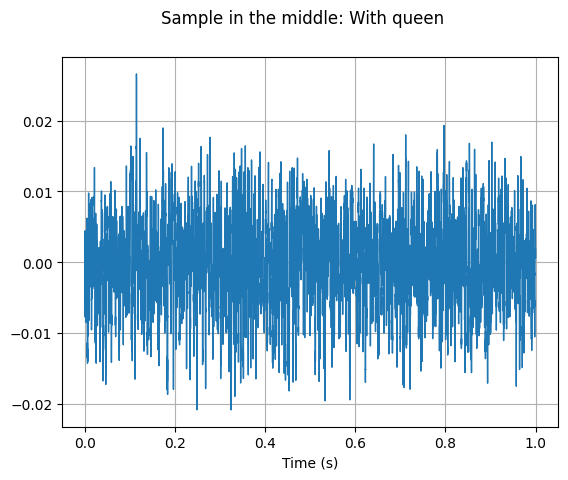
<br />
E mediante spettrogramma in Tempo/Frequenza/Intensità: <br />
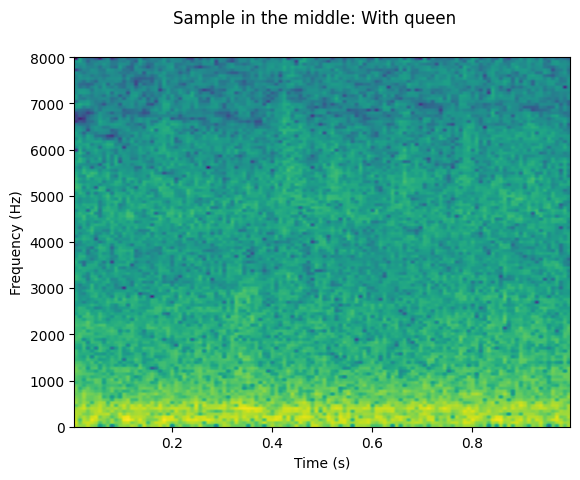

Visualizziamo i risultati mediante Confusion Matrix https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html:
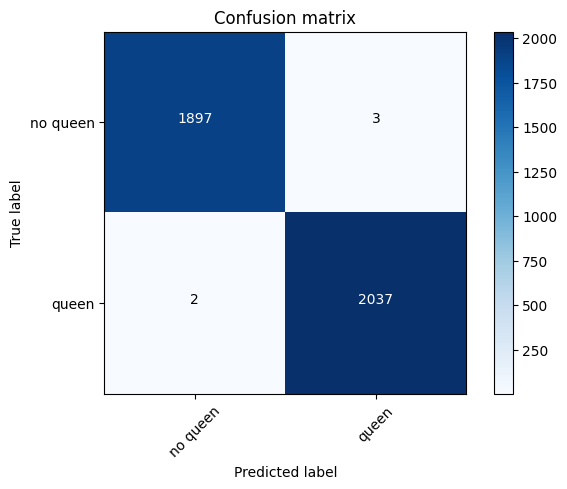



In [19]:
n_outputs = 2 # queen / no_queen
mode = 1 # metodo di estrazione delle feature stft_extraction con media
num_epochs = 50 # 50 numero di iterazioni
patience = 20 # 20 quante iterazioni andare avanti senza miglioramenti
num_batch_size = 145 # numero di features/labels per iterazione
n_input_channels = num_batch_size
class_names= ['no queen', 'queen' ]
directory = "/content/drive/MyDrive/BEEHIVE/128"


n_chunks = 37 # numero di bande frequenziali su cui fare la media (vedi articolo)

#train_evaluate(directory, n_outputs, num_batch_size,
#               num_epochs, class_names, n_chunks, mode, patience)

In [20]:
myDataset = CustomDataset(directory, n_chunks, mode)
data_shape = myDataset.getfeaturesshape()

n_input_channels = num_batch_size
# When creating the CNN model, pass the number of input channels
model = CNN(data_shape[1], data_shape[2], n_outputs, n_input_channels)  # Provide n_input_channels

# Instantiate and load your custom CNN model
#model = CNN(data_shape[1], data_shape[2], n_outputs)

File name:  ['25.11.2022', '2', 'under', 'hive', 'queenpresent.mp3']


<ipython-input-10-56bcfaedb1aa>:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  merged_sequence = np.add(merged_sequence, data[i, :])


Length in seconds:  479
File name:  ['25.11.2022', '1', 'under', 'hive', 'queenpresent.mp3']


<ipython-input-10-56bcfaedb1aa>:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  merged_sequence = np.add(merged_sequence, data[i, :])


Length in seconds:  607
File name:  ['25.11.2022', '13', 'under', 'hive', 'noqueen.mp3']
Length in seconds:  497
File name:  ['25.11.2022', '12', 'under', 'hive', 'noqueen.mp3']
Length in seconds:  602
File name:  ['25.11.2022', '11', 'under', 'hive', 'noqueen.mp3']
Length in seconds:  607
File name:  ['21.11.2022', 'under', 'hive', 'queenpresent.mp3']
Length in seconds:  583
File name:  ['19.11.2022', 'under', 'hive', '+10db', 'queenpresent.mp3']
Length in seconds:  450
File name:  ['24.11.2022', '1', 'under', 'hive', '+10db', 'mics 90°', 'queenpresent.mp3']
Length in seconds:  606
File name:  ['24.11.2022', '2', 'under', 'hive', '+10db', 'mics 90°', 'queenpresent.mp3']
Length in seconds:  612
File name:  ['24.11.2022', '3', 'under', 'hive', '+10db', 'mics 90°', 'queenpresent.mp3']
Length in seconds:  600
File name:  ['24.11.2022', '4', 'under', 'hive', '+10db', 'mics 90°', 'queenpresent.mp3']
Length in seconds:  618
File name:  ['24.11.2022', '5', 'under', 'hive', '+10db', 'mics 90°'

In [21]:
train_evaluate(directory, n_outputs, num_batch_size,
               num_epochs, class_names, n_chunks, mode, patience)

Device:  cuda
Creating dataset ...
File name:  ['25.11.2022', '2', 'under', 'hive', 'queenpresent.mp3']


<ipython-input-10-56bcfaedb1aa>:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  merged_sequence = np.add(merged_sequence, data[i, :])


Length in seconds:  479
File name:  ['25.11.2022', '1', 'under', 'hive', 'queenpresent.mp3']
Length in seconds:  607
File name:  ['25.11.2022', '13', 'under', 'hive', 'noqueen.mp3']
Length in seconds:  497
File name:  ['25.11.2022', '12', 'under', 'hive', 'noqueen.mp3']
Length in seconds:  602
File name:  ['25.11.2022', '11', 'under', 'hive', 'noqueen.mp3']
Length in seconds:  607
File name:  ['21.11.2022', 'under', 'hive', 'queenpresent.mp3']
Length in seconds:  583
File name:  ['19.11.2022', 'under', 'hive', '+10db', 'queenpresent.mp3']
Length in seconds:  450
File name:  ['24.11.2022', '1', 'under', 'hive', '+10db', 'mics 90°', 'queenpresent.mp3']
Length in seconds:  606
File name:  ['24.11.2022', '2', 'under', 'hive', '+10db', 'mics 90°', 'queenpresent.mp3']
Length in seconds:  612
File name:  ['24.11.2022', '3', 'under', 'hive', '+10db', 'mics 90°', 'queenpresent.mp3']
Length in seconds:  600
File name:  ['24.11.2022', '4', 'under', 'hive', '+10db', 'mics 90°', 'queenpresent.mp3']

In [ ]:
torch.save(model.state_dict(), 'bees.pth')

from google.colab import files
files.download('bees.pth')

In [ ]:
def count_tensors(model):
    total_tensors = 0
    for name, param in model.named_parameters():
        total_tensors += param.numel()
    for name, buf in model.named_buffers():
        total_tensors += buf.numel()
    return total_tensors

model.load_state_dict(torch.load('bees.pth'))
model.eval() # set dropout and batch normalization layers to evaluation mode before running inference

# Define input shape
batch_size = num_batch_size
input_shape = (batch_size, 37, 32)
dummy_input = torch.randn(input_shape)


with torch.no_grad():
    outputs = model(dummy_input)


# Count the tensors in the model
#num_tensors = count_tensors(model)
#print("Number of tensors in the model:", num_tensors)

#Export Your Custom CNN to ONNX
load the saved weights of your custom CNN model before exporting it

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


In [ ]:
#pip install onnx onnx_tf

#Convert PyTorch model to ONNX format:

Convert my PyTorch model into a TensorFlow-compatible format before converting it to TensorFlow Lite. First I export the PyTorch model to ONNX format and then I convert the ONNX model to TensorFlow Lite.

In [ ]:
# Export the model to ONNX
torch.onnx.export(model, dummy_input, "bees_model.onnx", verbose=True)


In [ ]:
#pip install tf2onnx

In [ ]:
#import onnx

from onnx_tf.backend import prepare

onnx_model = onnx.load("bees_model.onnx")  # load onnx model
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph("output_path")  # export the model

#Convert ONNX model to TensorFlow Lite:
The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
import tf2onnx

# Convert the ONNX model to TensorFlow Lite format
tf2onnx.convert.from_onnx(bees_model.onnx, tf_lite_path="bees_model.tflite")

# Save the model to disk
open("bees_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("bees_model.tflite")
print("Model is %d bytes" % basic_model_size)


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat bees_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Tinymlgen package has a single method called port(): it accepts a TensorFlow model and returns the C code you need to import in your Arduino sketch.

In [ ]:
pip install tinymlgen

from tinymlgen import port

if __name__ == '__main__':
    tf_model = create_tf_model()
    c_code = port(tf_model)

    with open('bees_model.h', 'w') as file:
        file.write(c_code)